In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [2]:
players = pd.read_pickle('players.pkl')
results = pd.read_pickle('results.pkl')
tournaments = pd.read_pickle('tournaments.pkl')

### Подсчет сложности турнира как средняя сложность вопроса

In [5]:
tournament_number_of_questions = {}
tournament_complexity_2019 = {}
tournament_complexity_2019_no_zeros = {}
tournament_complexity_2020 = {}
tournament_complexity_2020_no_zeros = {}
for tournament in tournaments.values():
    questionQty = tournament['questionQty']
    res = 0
    num_of_questions = 0
    if questionQty is not None:
        for complexity, num_of_questions_with_complexity in questionQty.items():
            res += int(complexity) * num_of_questions_with_complexity
            num_of_questions += num_of_questions_with_complexity
    if tournament['dateStart'] >= '2019-01-01' and tournament['dateStart'] < '2020-01-01':
        if num_of_questions != 0:
            tournament_complexity_2019[tournament['id']] = res/num_of_questions
        else:
            tournament_complexity_2019[tournament['id']] = 0
        if res != 0:
            tournament_complexity_2019_no_zeros[tournament['id']] = res/num_of_questions
        tournament_number_of_questions[tournament['id']] = num_of_questions
    elif tournament['dateStart'] >= '2020-01-01':
        if num_of_questions != 0:
            tournament_complexity_2020[tournament['id']] = res/num_of_questions
        else:
            tournament_complexity_2020[tournament['id']] = 0
        if res != 0:
            tournament_complexity_2020_no_zeros[tournament['id']] = res/num_of_questions
        tournament_number_of_questions[tournament['id']] = num_of_questions
            
print(len(tournament_complexity_2019))
print(len(tournament_complexity_2019_no_zeros))
print(len(tournament_complexity_2020))
print(len(tournament_complexity_2020_no_zeros))
print(len(tournament_number_of_questions))

tournament_complexity = tournament_complexity_2019
tournament_complexity.update(tournament_complexity_2020)

687
687
422
422
1109


### Подсчет сложности вопросов как процента правильных ответов и оценка рейтинга игроков 

In [8]:
tournament_ids_with_mask_number_of_questions_inconsistency = set()

player_real_rating_by_the_beginning_of_2019 = {}
player_real_rating_by_the_end_of_2019 = {}
player_estimated_rating_increase_in_2019 = {}

player_real_rating_by_the_beginning_of_2020 = {}
player_real_rating_by_the_end_of_2020 = {}
player_estimated_rating_increase_in_2020 = {}

for tournament_id, tournament_result in results.items():
    if tournament_id in tournament_number_of_questions:
        tournament_masks = []
        for team_result in tournament_result:
            if len(team_result['teamMembers']) > 0 and 'mask' in team_result and team_result['mask'] != None and len(team_result['mask']) >= tournament_number_of_questions[tournament_id]:
                team_mask = []
                for i in range(tournament_number_of_questions[tournament_id]):
                    question_result = team_result['mask'][i]
                    if question_result == '0' or question_result == '1':
                        team_mask.append(float(question_result))
                    else:
                        team_mask.append(0.5)
                tournament_masks.append(team_mask)
        if len(tournament_masks) == 0:
            tournament_ids_with_mask_number_of_questions_inconsistency.add(tournament_id)
        else:
            tournament_question_complexity = 1 - np.mean(np.array(tournament_masks), axis=0)
            for team_result in tournament_result:
                if len(team_result['teamMembers']) > 0 and 'mask' in team_result and team_result['mask'] != None and len(team_result['mask']) >= tournament_number_of_questions[tournament_id]:
                    team_mask = []
                    for i in range(tournament_number_of_questions[tournament_id]):
                        question_result = team_result['mask'][i]
                        if question_result == '0' or question_result == '1':
                            team_mask.append(float(question_result))
                        else:
                            team_mask.append(0.5)
                    estimated_rating_increase = tournament_complexity[tournament_id] * np.dot(tournament_question_complexity, team_mask)
                    for player in team_result['teamMembers']:
                        player_id = player['player']['id']
                        player_rating = player['rating']
                        if tournaments[tournament_id]['dateStart'] < '2020-01-01':
                            if player_id not in player_real_rating_by_the_beginning_of_2019:
                                player_real_rating_by_the_beginning_of_2019[player_id] = player_rating
                                player_real_rating_by_the_end_of_2019[player_id] = player_rating
                                player_estimated_rating_increase_in_2019[player_id] = estimated_rating_increase
                            else:
                                player_real_rating_by_the_end_of_2019[player_id] = player_rating
                                player_estimated_rating_increase_in_2019[player_id] += estimated_rating_increase
                        else:
                            if player_id not in player_real_rating_by_the_beginning_of_2020:
                                player_real_rating_by_the_beginning_of_2020[player_id] = player_rating
                                player_real_rating_by_the_end_of_2020[player_id] = player_rating
                                player_estimated_rating_increase_in_2020[player_id] = estimated_rating_increase
                            else:
                                player_real_rating_by_the_end_of_2020[player_id] = player_rating
                                player_estimated_rating_increase_in_2020[player_id] += estimated_rating_increase
                        
print(len(tournament_ids_with_mask_number_of_questions_inconsistency))

262


### Baseline-модель, обучающая рейтинг-лист игроков

57429
57429
30409
30409
0.3923989515795282


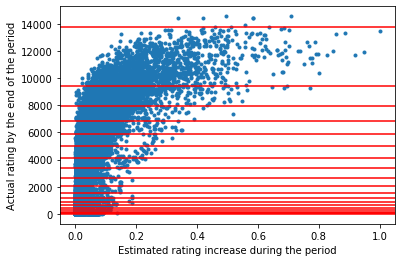

In [49]:
def get_category_upper_borders(array, num_of_categories):
    array_sorted = np.sort(array)
    category_size = int(len(array_sorted) / num_of_categories)
    category_upper_borders = []
    for i in range(num_of_categories):
        category_upper_border_index = (i + 1) * category_size - 1
        category_upper_borders.append(array_sorted[category_upper_border_index])
    return category_upper_borders

def get_category(element, category_upper_borders):
    num_of_categories = len(category_upper_borders)
    for i in range(num_of_categories):
        if element <= category_upper_borders[i]:
            return i
    return num_of_categories - 1

x_train = np.array(list(player_estimated_rating_increase_in_2019.values()))
print(len(x_train))
y_train = np.array(list(player_real_rating_by_the_end_of_2019.values()))
print(len(y_train))
x_train = x_train[y_train != 0]
print(len(x_train))
y_train = y_train[y_train != 0]
print(len(y_train))
x_train = np.interp(x_train, (x_train.min(), x_train.max()), (0, 1))
plt.scatter(x_train, y_train, marker='.')
plt.xlabel("Estimated rating increase during the period")
plt.ylabel("Actual rating by the end of the period")
category_upper_borders = get_category_upper_borders(y_train, 20)
y_train = np.array([get_category(y, category_upper_borders) for y in y_train])
for border in category_upper_borders:
    plt.axhline(y=border, color='red')
    
clf = LogisticRegression(random_state=0).fit(x_train.reshape(-1, 1), y_train)

x_test = np.array(list(player_estimated_rating_increase_in_2020.values()))
x_test = np.interp(x_test, (x_test.min(), x_test.max()), (0, 1))
y_test = np.array(list(player_real_rating_by_the_end_of_2020.values()))
y_test = np.array([get_category(y, category_upper_borders) for y in y_test])

score = clf.score(x_test.reshape(-1, 1), y_test)
print(score)